In [2]:
library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(gridExtra)
library(cowplot)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Predicting the length of tennis games using previous winners' height and age

## Introduction

In the dataset provided by Jeff Sackman, data from tennis matches played by the top 500 players from 2017 to 2019 are provided, with game statistics as well as winner and loser attributes. The data contains 6866 rows of games played in many tournaments from 2017 to 2019. The attributes given include information of the match such as its date, location, type of surface (hard, grass, etc), as well as the length of the match. Information is also given regarding the winners and losers, such as their height, age, dominant hand, and seed **description  and reference needed** Based on these data, we will use multivariable linear regression to predict the length of future tennis matches based on the height and age of winners of previously played tennis matches. Using these data, we will attempt to answer the question: can we predict the length of tennis matches based on the age and height of previous winners? 


In [3]:
tennis_data <- read_csv("https://raw.githubusercontent.com/keelbeier/dsci100-group69/main/atp2017-2019.csv")
tennis_data

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2883,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,2,104542,NA,⋯,54,30,12,12,5,11,15,2320,76,667
2884,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,4,105676,NA,⋯,54,44,13,14,7,10,7,3775,15,2320
2885,2017-M-DC-2017-WG-M-BEL-FRA-01,Davis Cup WG F: BEL vs FRA,Hard,4,D,20171124,5,106298,NA,⋯,53,29,11,11,4,11,18,2235,76,667



Above: our csv file read into R

## Methods

We used linear regression to predict the game length based on the age and height of previous winners and losers since we are trying to predict a quantitative variable. We originally planned to use only the dataset of winners but since there are 2 players per game, we thought it was also important to analyze the loser’s side.

We wrangled our dataset and selected the “winner_age”, “winner_ht”, “loser_age”, "loser_ht", and “minutes”  columns to make our training data set.  

In [4]:
tennis_data <- tennis_data |>
                    select(tourney_date, 
                      winner_age, loser_age, winner_ht, loser_ht, minutes) |>
                    mutate(winner_age = round(winner_age)) |>
                    mutate(loser_age = round(loser_age))|>
                    filter(winner_ht != "NA")
tennis_data

tourney_date,winner_age,loser_age,winner_ht,loser_ht,minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20181231,29,23,178,NA,124
20181231,29,32,178,188,66
20181231,34,20,188,NA,106
⋮,⋮,⋮,⋮,⋮,⋮
20171124,33,34,188,178,106
20171124,27,33,163,188,164
20171124,24,34,185,178,94


We then used the summarize function to calculate the median of each column.

In [5]:
tennis_parameter <- tennis_data |>
    summarize(med_winner_age = median(winner_age), 
              med_loser_age = median(loser_age), 
              med_winner_ht = median(winner_ht), 
              med_loser_ht = median(loser_ht, na.rm = TRUE), 
              med_minute = median(minutes, na.rm = TRUE))
tennis_parameter

med_winner_age,med_loser_age,med_winner_ht,med_loser_ht,med_minute
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
30,28,185,185,104


We visualized our results by using the ggplot2 function in the tidyverse package.
We plotted histograms to show the distribution of winner age, winner height, loser age, loser height, and game length. The function used was geom_histogram.

Warning message:
“Removed 1758 rows containing non-finite values (stat_bin).”
Warning message:
“Removed 73 rows containing non-finite values (stat_bin).”


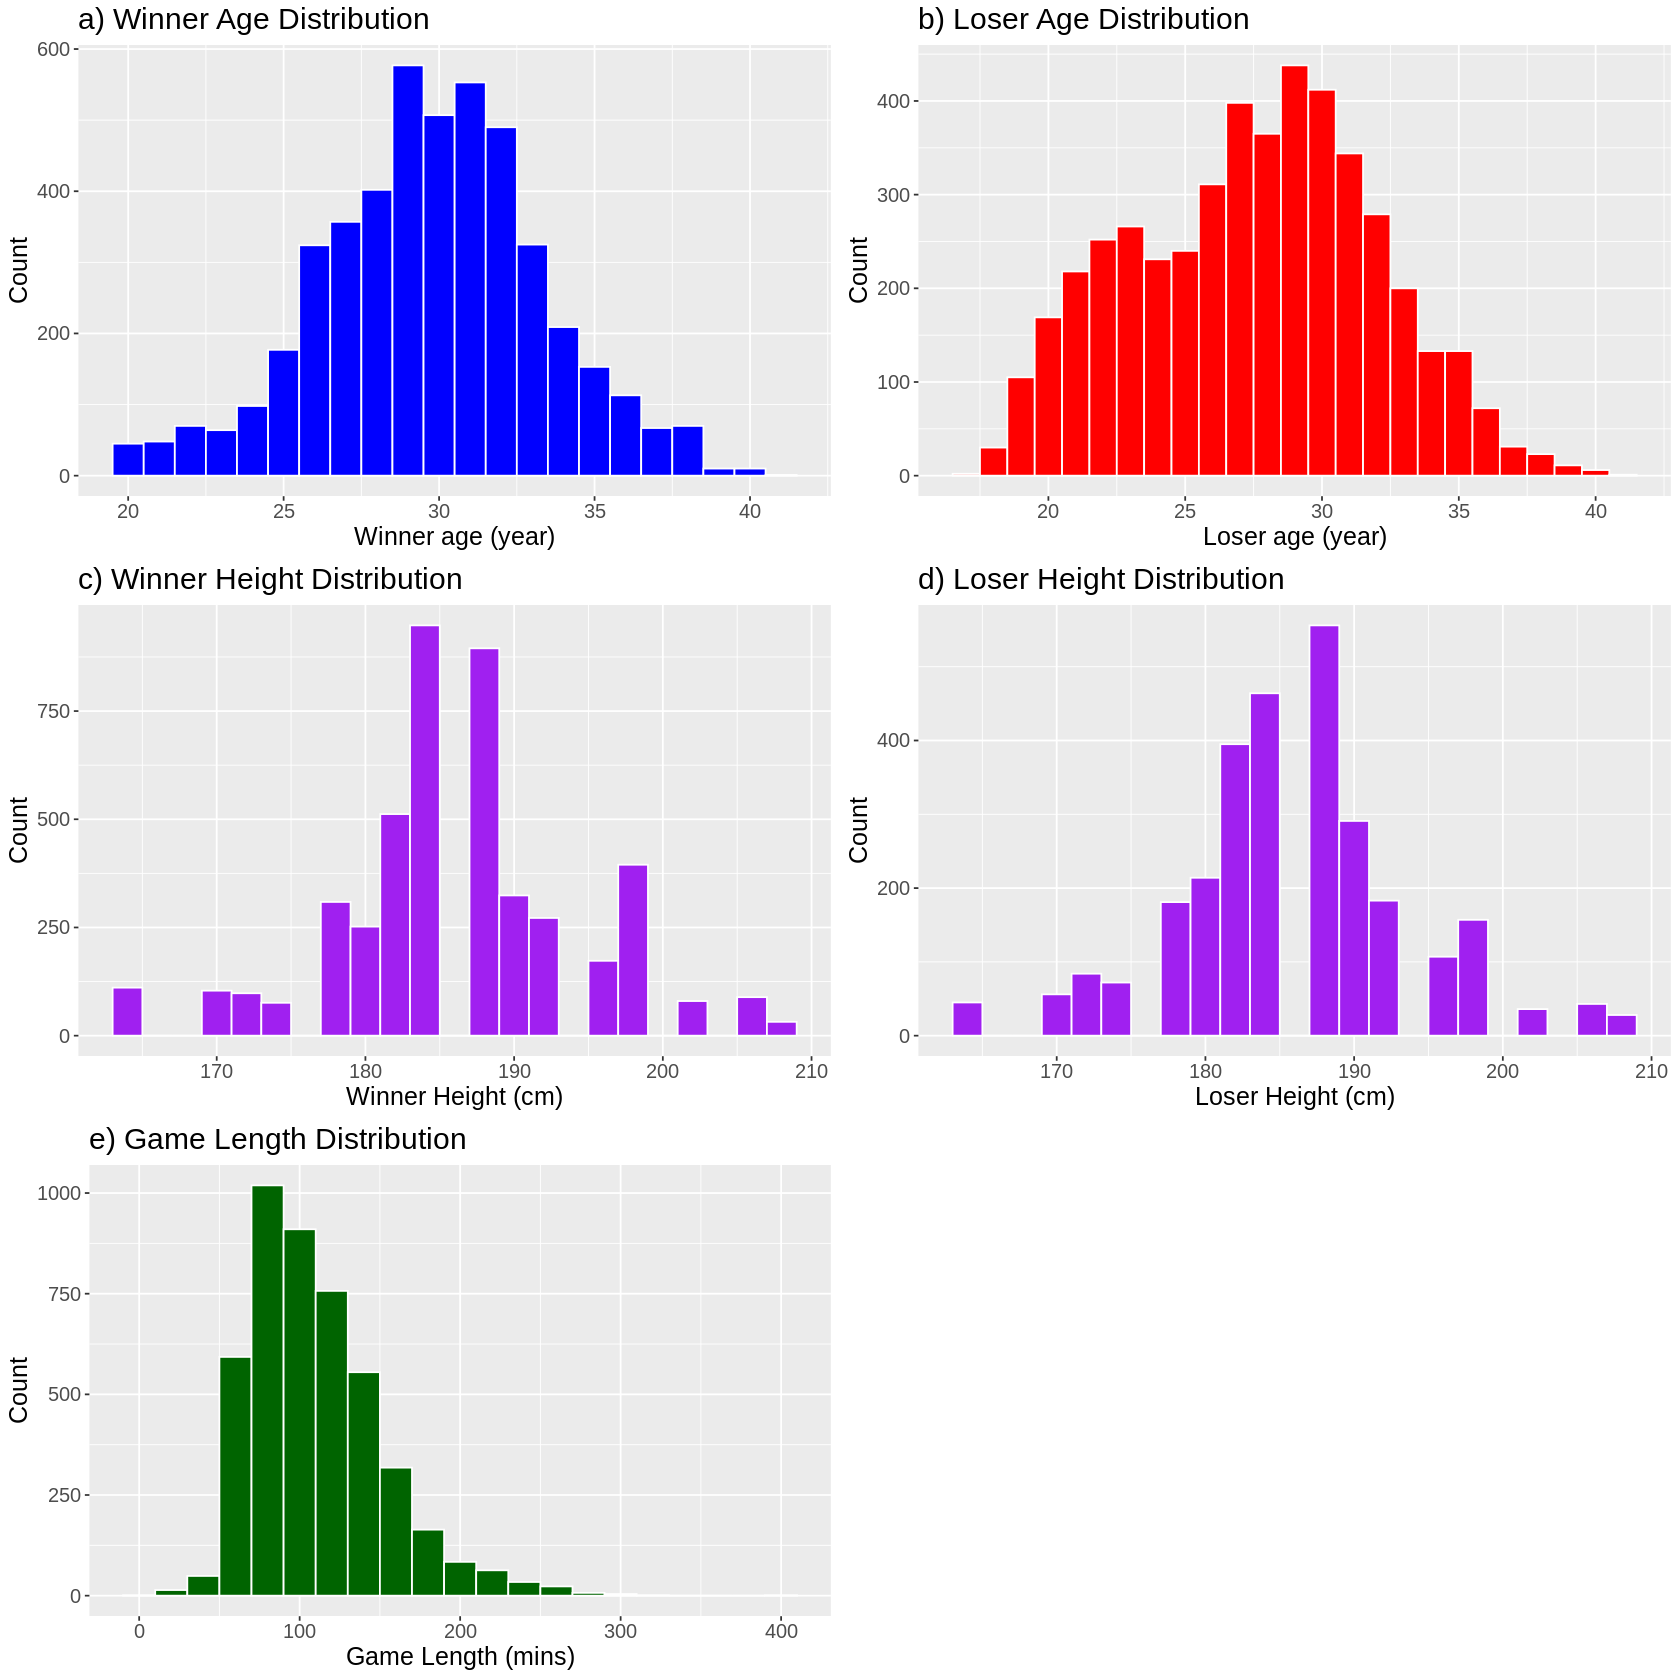

In [6]:
options(repr.plot.width=14, repr.plot.height=14)
winner_age_plot <- tennis_data |> 
    ggplot(aes(x = winner_age)) +
    geom_histogram(binwidth = 1, col = "white", fill = "blue") +
    labs(x = "Winner age (year)",
        y = "Count")+
    ggtitle("a) Winner Age Distribution") +
    theme(text = element_text(size = 15))

loser_age_plot <- tennis_data |> 
    ggplot(aes(x = loser_age)) +
    geom_histogram(binwidth = 1, col = "white", fill = "red") +
    labs(x = "Loser age (year)",
        y = "Count")+
    ggtitle("b) Loser Age Distribution") +
    theme(text = element_text(size = 15))

winner_ht_plot <- tennis_data |> 
    ggplot(aes(x = winner_ht)) +
    geom_histogram(binwidth = 2, col = "white", fill = "purple") +
    labs(x = "Winner Height (cm)",
        y = "Count") +
    ggtitle("c) Winner Height Distribution")+
    theme(text = element_text(size = 15))

loser_ht_plot <- tennis_data |> 
    ggplot(aes(x = loser_ht)) +
    geom_histogram(binwidth = 2, col = "white", fill = "purple") +
    labs(x = "Loser Height (cm)",
        y = "Count") +
    ggtitle("d) Loser Height Distribution")+
    theme(text = element_text(size = 15))

time_plot <- tennis_data |> 
    ggplot(aes(x = minutes)) +
    geom_histogram(binwidth = 20, col = "white", fill = "dark green") +
    labs(x = "Game Length (mins)",
        y = "Count") +
    ggtitle("e) Game Length Distribution")+
    theme(text = element_text(size = 15))

plot_grid(winner_age_plot, loser_age_plot, winner_ht_plot, loser_ht_plot, time_plot, ncol = 2)

**Figure 1.** **a)** Winner age distribution. Distribution is normal about the median of 30 years old. **b)** Loser age distribution. Distribution shows a slight right skew, indicating that losers are more likely to be below the age of 30, in which the median age is 28 years old. **c)** Winner height distribution. The distribution is normal about the median 185 cm. **d)** Loser height distribution. The distribution is normal about the median 185 cm. **e)** Distribution of game length in minutes. The distribution shows a right skew, indicating that game length is more likely to fall below 150 minutes, in which the median is 104 minutes. 

We then plotted scatter plots to show the correlation between game length and age/height of winners and losers, with age on the x-axis and age/height on the y-axis. The function used to create the graphs was geom_point.

Warning message:
“Removed 73 rows containing missing values (geom_point).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”
Warning message:
“Removed 1806 rows containing missing values (geom_point).”


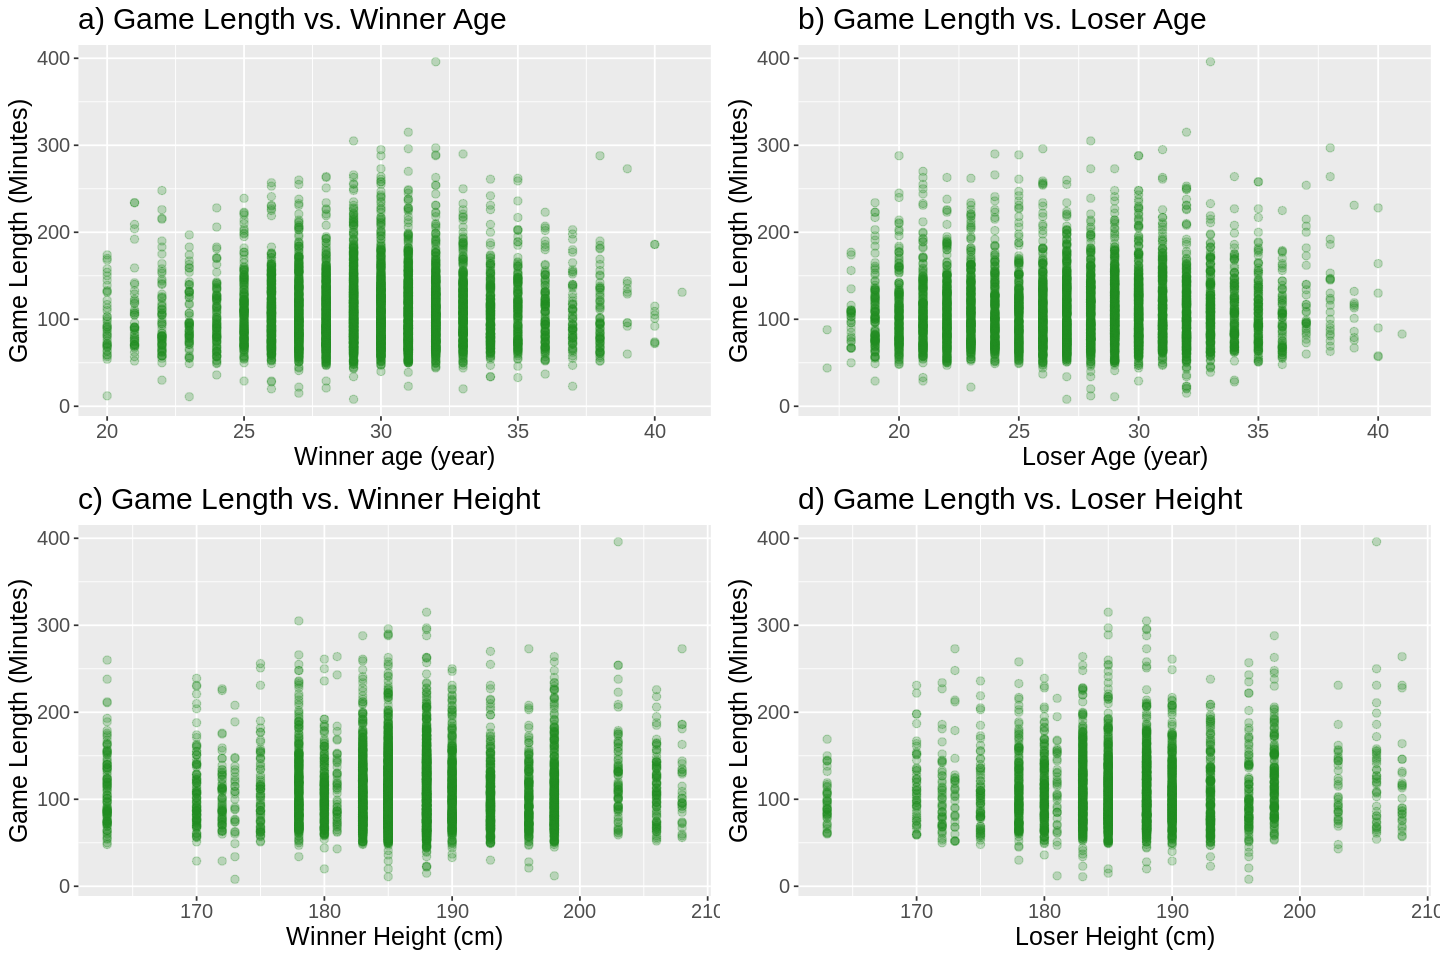

In [7]:
options(repr.plot.width=12, repr.plot.height=8)
winner_age_scatter_plot <- tennis_data |> 
    ggplot(aes(x = winner_age, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Winner Height",) +
    labs(x = "Winner age (year)",
        y = "Game Length (Minutes)") +
    ggtitle("a) Game Length vs. Winner Age") +
    theme(text = element_text(size = 15))

loser_age_scatter_plot <- tennis_data |> 
    ggplot(aes(x = loser_age, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Loser Age (year)",
        y = "Game Length (Minutes)") +
    ggtitle("b) Game Length vs. Loser Age") +
    theme(text = element_text(size = 15))

winner_ht_scatter_plot <- tennis_data |> 
    ggplot(aes(x = winner_ht, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Winner Height (cm)",
        y = "Game Length (Minutes)") +
    ggtitle("c) Game Length vs. Winner Height")  +
    theme(text = element_text(size = 15))

loser_ht_scatter_plot <- tennis_data |> 
    ggplot(aes(x = loser_ht, y = minutes)) +
    geom_point(alpha = 0.25, size = 2, col = "forest green") +
    labs(x = "Loser Height (cm)",
        y = "Game Length (Minutes)") +
    ggtitle("d) Game Length vs. Loser Height")  +
    theme(text = element_text(size = 15))

plot_grid(winner_age_scatter_plot, loser_age_scatter_plot, winner_ht_scatter_plot, loser_ht_scatter_plot, ncol = 2)

**Figure 2.** **a)** Winner age versus game length, the data point is distributed widely over the graph, as there are multiple players with the same age. **b)** Loser age versus game length. Data widely distributed, similar to graph a). **c)** Winner height versus game length. Data widely distributed. However, compared with age's data, the height data form more clusters as there are more players with the same height. **d)** Loser height versus game length, graph shape is similar with graph c). 

Next, we split our dataset into training and testing. We used 0.6 proportion to split the dataset. We created different model specifications and recipes for the winner and loser dataset to give us different linear regression coefficients. 

In [8]:
data_split <- initial_split(tennis_data, prop = 0.6, strata = minutes)
data_train <- training(data_split)
data_test <- testing(data_split)

In [9]:
set.seed(2000)

lm_spec <- linear_reg()|>
    set_engine("lm")|>
    set_mode("regression")

lm_recipe <- recipe(minutes ~ winner_ht + winner_age, data = data_train)

lm_fit <- workflow()|>
    add_recipe(lm_recipe)|>
    add_model(lm_spec) |>
    fit(data = data_train)
lm_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    winner_ht   winner_age  
  106.92275     -0.04373      0.41594  


In [10]:
set.seed(2000)

loser_lm_recipe <- recipe(minutes ~ loser_age + loser_ht, data = data_train)

loser_fit <- workflow()|>
    add_recipe(loser_lm_recipe)|>
    add_model(lm_spec) |>
    fit(data = data_train)
loser_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)    loser_age     loser_ht  
    72.0550      -0.4487       0.2867  


After getting the coefficients, we have the following formulas:

Game length = 101.96458 + 0.00909 * (winner height) + 0.23887 * (winner age)

Game length = 70.22770 + 0.21190 * (loser height) + 0.06685 * (winner age)

## Results

Once we set the model specification for both winner and loser datasets, 
Our results gave us a RMSPE of 41.766 for the winner dataset and a RMSPE of 42.518 for the loser dataset.
We also included the linear regression model into our scatter plots from before to visualize the line of best fit from all graphs. As we don't have sufficient knowledge to create 3-dimensional graphs for multivariable correlation, we would instead draw one graph for each predictor. 

In [11]:
lm_test_result <- lm_fit |>
    predict(data_test) |>
    bind_cols(data_test) |>
    metrics(truth = minutes, estimate = .pred)
lm_test_result
lm_coeffs <- lm_fit |>
    extract_fit_parsnip() |>
    tidy()
lm_coeffs

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,4.098873e+01
rsq,standard,5.198333e-04
mae,standard,3.210628e+01


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),106.92275262,18.62085689,5.7420963,1.037420e-08
winner_ht,-0.04372772,0.09644698,-0.4533861,6.503065e-01
winner_age,0.41594362,0.22263271,1.8682952,6.182708e-02


In [12]:
loser_lm_test_result <- loser_fit |>
    predict(data_test) |>
    bind_cols(data_test) |>
    metrics(truth = minutes, estimate = .pred)
loser_lm_test_result
loser_lm_coeffs <- loser_fit |>
    extract_fit_parsnip() |>
    tidy()
loser_lm_coeffs

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,41.732143606
rsq,standard,0.001775502
mae,standard,32.597081023


term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),72.0549908,25.5618696,2.818847,0.00487582
loser_age,-0.4486823,0.3121574,-1.437359,0.15080108
loser_ht,0.2866844,0.1342303,2.135765,0.03284198


`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”


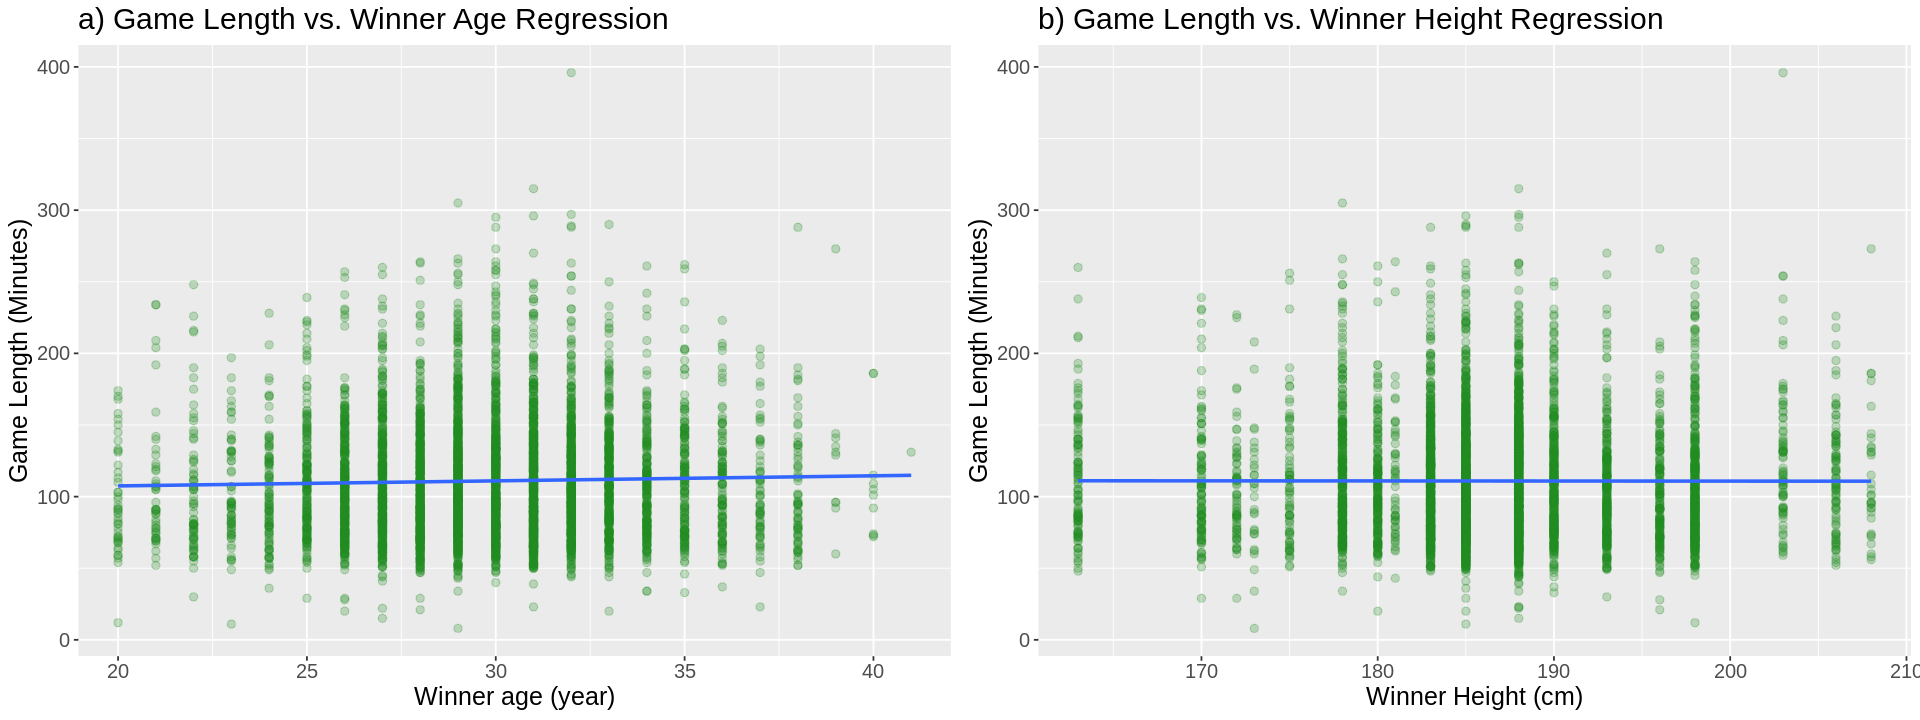

In [15]:
options(repr.plot.width=16, repr.plot.height=6)
regression_age_plot <- winner_age_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("a) Game Length vs. Winner Age Regression")

regression_winner_ht_plot <- winner_ht_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("b) Game Length vs. Winner Height Regression")

plot_grid(regression_age_plot, regression_winner_ht_plot, ncol = 2)

**Figure 3.** **a)** Winner age versus game length with regression line. Data point is distributed widely over the graph. The regression line shows a weak positive trend. **b)** Loser age versus game length with regression line. Data point is distributed widely over the graph. The regression line is almost a horizontal straight line. 

`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 73 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 73 rows containing missing values (geom_point).”
`geom_smooth()` using formula 'y ~ x'

Warning message:
“Removed 1806 rows containing non-finite values (stat_smooth).”
Warning message:
“Removed 1806 rows containing missing values (geom_point).”


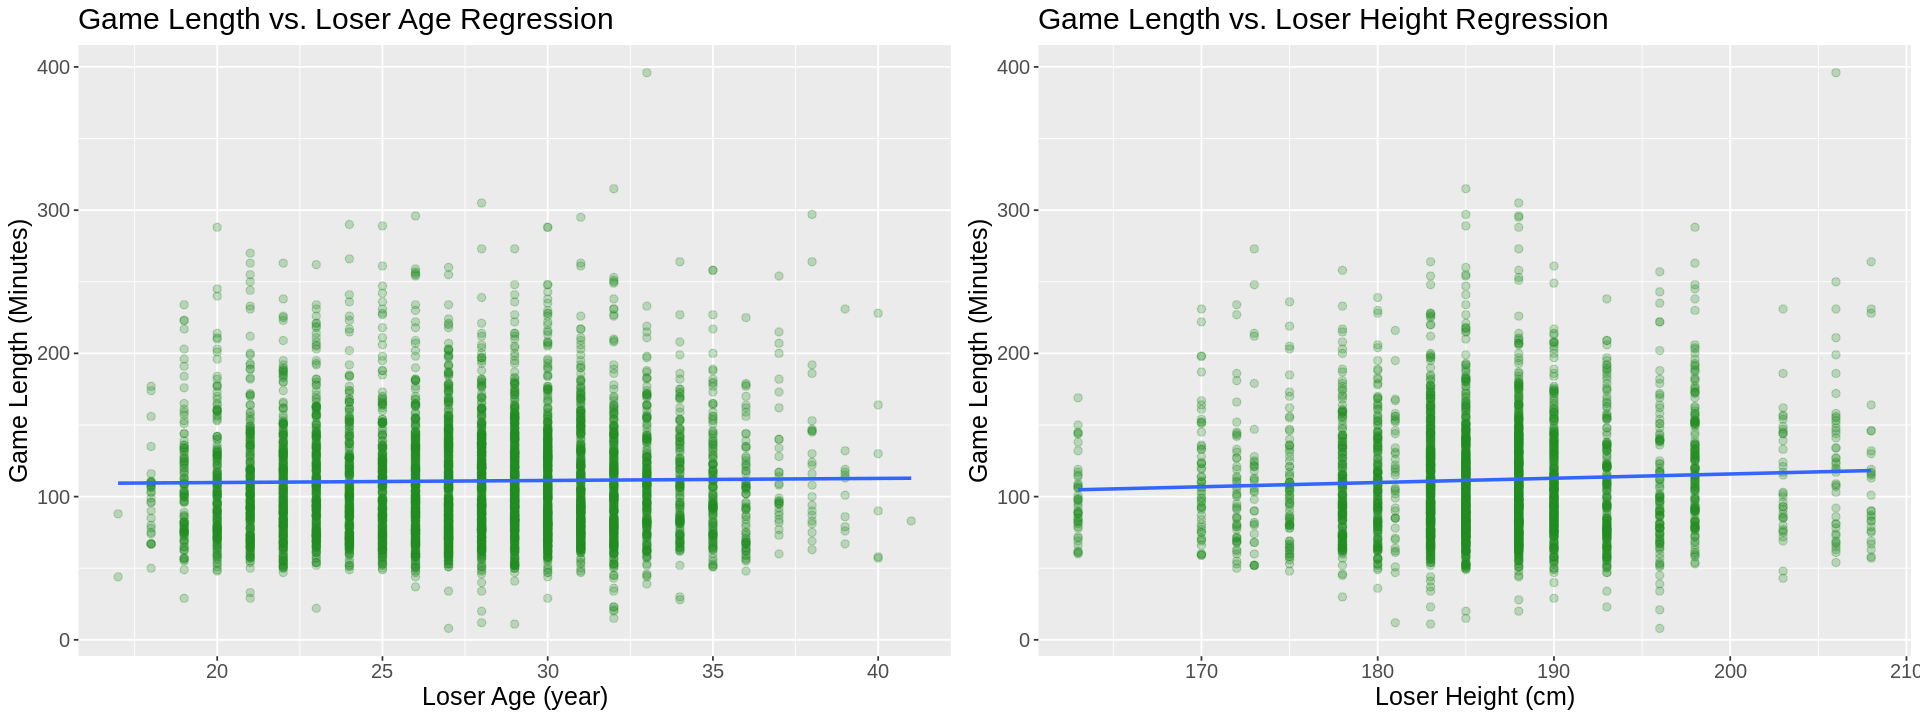

In [14]:
regression_loser_age_plot <- loser_age_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("a) Game Length vs. Loser Age Regression")

regression_loser_ht_plot <- loser_ht_scatter_plot + 
    geom_smooth(method = "lm", se = FALSE) + 
    ggtitle("b) Game Length vs. Loser Height Regression")

plot_grid(regression_loser_age_plot, regression_loser_ht_plot, ncol = 2)

**Figure 4.** **a)** Winner height versus game length with regression line. Data point is distributed widely over the graph. The regression line is almost a horizontal straight line. **b)** Loser height versus game length with regression line. Data point is distributed widely over the graph. The regression line shows a slight positive trend. 

## Discussion

According to our model, we found that game length has a weak but positive relationship between winner ages and winner heights, and loser ages and loser heights. We would conclude that there is no linear correlation between the variables. Looking at the regression graphs, we could see that there is no clear trend of the data points. The range of the data is large so that the data is distributed all over the graph. In addition, the trend of the regression line is almost like a straight line, which means that it failed to find a positive or negative trend for the prediction. The large RMSPE and p value calculated in the result further proves that the linear regression model is not an accurate fit for the data. The p value for every variable is greater than 0.05 (0.865 for winner height, 0.482 for winner age, 0.052 for loser height, and 0.750 for loser age), meaning that there's no relationship discovered between the variables. In brief, the linear regression seems to be insignificant and could not be used for accurate real life estimation. 

We initially planned to use k-nearest neighbor regression model since we don't think the relationship is linear, but the data set is too large to be processed so we used linear regression model instead. We were expecting to find a positive correlation for the result so the actual result seems to fit the expectation. However, the insignificant relationship would be difficult for us to precisely calculate the approximate game length based on the players’ information we chose. For further investigation, we could try to use different variables from the data frame, or tidy the data set more and use k-nearest neighbors model to see if any reliable correlation could be discovered. Using the player’s information to predict game length could be useful for audience of tennis matches, in which they could know in advance the amount of time they would spend to watch a specific game. 

## References

Sackmann, J. (n.d.). Jeffsackmann/TENNIS_ATP: ATP Tennis Rankings, results, and stats. GitHub. https://github.com/JeffSackmann/tennis_atp 